In [1]:
# # From Laurens van der Maaten
# #  tsne.py
# #
# # Implementation of t-SNE in Python. The implementation was tested on Python
# # 2.7.10, and it requires a working installation of NumPy. The implementation
# # comes with an example on the MNIST dataset. In order to plot the
# # results of this example, a working installation of matplotlib is required.
# #
# # The example can be run by executing: `ipython tsne.py`
# #
# #
# #  Created by Laurens van der Maaten on 20-12-08.
# #  Copyright (c) 2008 Tilburg University. All rights reserved.

# import numpy as np
# import pylab


# def Hbeta(D=np.array([]), beta=1.0):
#     """
#         Compute the perplexity and the P-row for a specific value of the
#         precision of a Gaussian distribution.
#     """

#     # Compute P-row and corresponding perplexity
#     P = np.exp(-D.copy() * beta)
#     sumP = sum(P)
#     H = np.log(sumP) + beta * np.sum(D * P) / sumP
#     P = P / sumP

#     print(D.shape)
#     print(P.shape)
#     print(np.sum(D * P))
#     # return H, P


# def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
#     """
#         Performs a binary search to get P-values in such a way that each
#         conditional Gaussian has the same perplexity.
#     """

#     # Initialize some variables
#     print("Computing pairwise distances...")
#     (n, d) = X.shape
#     sum_X = np.sum(np.square(X), 1)
#     D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
#     P = np.zeros((n, n))
#     beta = np.ones((n, 1))
#     logU = np.log(perplexity)

#     # Loop over all datapoints
#     for i in range(n):

#         # Print progress
#         if i % 500 == 0:
#             print("Computing P-values for point %d of %d..." % (i, n))

#         # Compute the Gaussian kernel and entropy for the current precision
#         betamin = -np.inf
#         betamax = np.inf
#         Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
#         (H, thisP) = Hbeta(Di, beta[i])

#         # Evaluate whether the perplexity is within tolerance
#         Hdiff = H - logU
#         tries = 0
#         while np.abs(Hdiff) > tol and tries < 50:

#             # If not, increase or decrease precision
#             if Hdiff > 0:
#                 betamin = beta[i].copy()
#                 if betamax == np.inf or betamax == -np.inf:
#                     beta[i] = beta[i] * 2.
#                 else:
#                     beta[i] = (beta[i] + betamax) / 2.
#             else:
#                 betamax = beta[i].copy()
#                 if betamin == np.inf or betamin == -np.inf:
#                     beta[i] = beta[i] / 2.
#                 else:
#                     beta[i] = (beta[i] + betamin) / 2.

#             # Recompute the values
#             (H, thisP) = Hbeta(Di, beta[i])
#             Hdiff = H - logU
#             tries += 1

#         # Set the final row of P
#         P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

#     # Return final P-matrix
#     print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
#     return P


# def pca(X=np.array([]), no_dims=50):
#     """
#         Runs PCA on the NxD array X in order to reduce its dimensionality to
#         no_dims dimensions.
#     """

#     print("Preprocessing the data using PCA...")
#     (n, d) = X.shape
#     X = X - np.tile(np.mean(X, 0), (n, 1))
#     (l, M) = np.linalg.eig(np.dot(X.T, X))
#     Y = np.dot(X, M[:, 0:no_dims])
#     return Y


# def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
#     """
#         Runs t-SNE on the dataset in the NxD array X to reduce its
#         dimensionality to no_dims dimensions. The syntaxis of the function is
#         `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
#     """

#     # Check inputs
#     if isinstance(no_dims, float):
#         print("Error: array X should have type float.")
#         return -1
#     if round(no_dims) != no_dims:
#         print("Error: number of dimensions should be an integer.")
#         return -1

#     # Initialize variables
#     X = pca(X, initial_dims).real
#     (n, d) = X.shape
#     max_iter = 1000
#     initial_momentum = 0.5
#     final_momentum = 0.8
#     eta = 500
#     min_gain = 0.01
#     Y = np.random.randn(n, no_dims)
#     dY = np.zeros((n, no_dims))
#     iY = np.zeros((n, no_dims))
#     gains = np.ones((n, no_dims))

#     # Compute P-values
#     P = x2p(X, 1e-5, perplexity)
#     P = P + np.transpose(P)
#     P = P / np.sum(P)
#     P = P * 4.									# early exaggeration
#     P = np.maximum(P, 1e-12)

#     # Run iterations
#     for iter in range(max_iter):

#         # Compute pairwise affinities
#         sum_Y = np.sum(np.square(Y), 1)
#         num = -2. * np.dot(Y, Y.T)
#         num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
#         num[range(n), range(n)] = 0.
#         Q = num / np.sum(num)
#         Q = np.maximum(Q, 1e-12)

#         # Compute gradient
#         PQ = P - Q
#         for i in range(n):
#             dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

#         # Perform the update
#         if iter < 20:
#             momentum = initial_momentum
#         else:
#             momentum = final_momentum
#         gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
#                 (gains * 0.8) * ((dY > 0.) == (iY > 0.))
#         gains[gains < min_gain] = min_gain
#         iY = momentum * iY - eta * (gains * dY)
#         Y = Y + iY
#         Y = Y - np.tile(np.mean(Y, 0), (n, 1))

#         # Compute current value of cost function
#         if (iter + 1) % 10 == 0:
#             C = np.sum(P * np.log(P / Q))
#             print("Iteration %d: error is %f" % (iter + 1, C))

#         # Stop lying about P-values
#         if iter == 100:
#             P = P / 4.

#     # Return solution
#     return Y



# print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
# print("Running example on 2,500 MNIST digits...")
# X = subset.iloc[:,:-1]
# labels = subset['label']
# Y = tsne(X, 2, 50, 20.0)
# pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
# pylab.show()


# NULL

In [2]:
import numpy as np
import pandas as pd
import time

## MNIST handwritten dataset

In [3]:
from sklearn.datasets import fetch_openml
# load MNIST dataset
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target

print(X.shape)
print(y.shape)
print(y.value_counts())

data = X.copy()
data['label'] = y
X = None
y = None
print('done')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: class, dtype: int64
done


#T-SNE

##Gaussian Distribution for HIGH-Dimension data

calculate distance

In [4]:
def cal_dis(X):
  '''
    X - data matrix(n rows * d dimensions)
    calculate the Euclidean distance
    Using Matrix Operations to speed up

    return D - square distance matrix
    e.g. D[i][j] - the square distance between i and j   (xi - xj)**2
  '''

  sum_X = np.sum(np.square(X), 1)
  D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
  return D

equation (1).svg

In [5]:
def calc_P_and_entropy(D=np.array([]), beta=1.0):
  '''
    D - the square distance
    beta - 1 / 2 * (sigma**2)

    return P - Gaussian distribution matrix (like D)
        log_perplexity - for calculating the gradient
  '''

  # P - p[i][j]
  P = np.exp(-D.copy() * beta)
  sumP = np.sum(P)

  # try to change beta to make log_perplexity be closer with H
  # H = -sum(p j|i) * logp j|i
  log_perplexity = np.log(sumP) + beta * (np.sum(D * P) / sumP)
  P = P/sumP
  return P, log_perplexity

In [6]:
def b_search_beta(D, init_beta, tol=1e-5, perplexity=30.0, max_iter=50):
  """
    Performs a binary search to get P-values in such a way that each
    conditional Gaussian has the same perplexity.

    D - distance
    tol - finish search if the difference less than the value of tol
    perplexity - hyperparameter

    return P - Optimized probability matrix
        beta - Optimized beta

  """

  beta_max = np.inf
  beta_min = -np.inf
  beta = init_beta


  P, log_entropy = calc_P_and_entropy(D, beta)
  diff_log_entropy = log_entropy - np.log(perplexity)


  iter = 0
  # entropy is inversely related to beta
  while np.abs(diff_log_entropy)>tol and iter<max_iter:
      if diff_log_entropy>0:
          beta_min = beta
          if beta_max == np.inf or beta_max == -np.inf:
              beta = beta*2
          else:
              beta = (beta+beta_max)/2.

      else:
          beta_max = beta
          if beta_min == -np.inf or beta_min == -np.inf:
              beta = beta/2
          else:
              beta = (beta + beta_min)/2.

      # compute the entrop again
      P, log_entropy=calc_P_and_entropy(D, beta)
      diff_log_entropy = log_entropy - np.log(perplexity)
      iter = iter+1

  return P, beta

Compute the joint possibility

equation (2).svg

In [7]:
def p_joint(X, perplexity=30):
  '''
    X - data matrix(n rows * d dimensions)
    perplexity - hyperparameter

    return P_join the joint possibility matrix
  '''
  (N, D) = X.shape
  distances = cal_dis(X)
  beta = np.ones((N, 1))

  p_conditional = np.zeros([N,N])
  # Search for the optimal sigma(beta) for each sample point
  # and calculate the corresponding P
  for i in range(N):
    if i % 500 ==0:
      print("Compute joint P for %d points" % (i))
    # Remove datapoints on the diagonal
    Di = np.delete(distances[i,:],i)
    # binary search to get beta
    # let the diff log-entropy be minimized
    P, beta[i] = b_search_beta(Di, beta[i], perplexity=perplexity)

    # fill up '0' at the deleted position
    p_conditional[i] = np.insert(P,i,0)

  # Make it symmetric
  P_join = p_conditional + p_conditional.T
  P_join = P_join / np.sum(P_join)

  # show the value of optimized beta
  print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))

  return P_join

##students t(Cauchy)  distribution for LOW-Dimension data

fb4fd37d4f9ead6783db00336e3a44f9cefff318.svg

In [8]:
def q_t_distribution(Y):
  N = np.shape(Y)[0]
  sum_Y = np.sum(np.square(Y), 1)
  num = -2. * np.dot(Y, Y.T)
  num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
  num[range(N), range(N)] = 0.
  Q = num / np.sum(num)
  Q = np.maximum(Q, 1e-12)
  # return numerators to compute the gradient
  return Q, num

##PCA

In [9]:
def pca(X=np.array([]), no_dims=50):
  """
    Runs PCA on the NxD array X in order to reduce its dimensionality to
    no_dims dimensions.
  """

  print("Preprocessing the data using PCA...")
  (n, d) = X.shape
  X = X - np.tile(np.mean(X, 0), (n, 1))
  (l, M) = np.linalg.eig(np.dot(X.T, X))
  Y = np.dot(X, M[:, 0:no_dims])
  return Y

##T-SNE

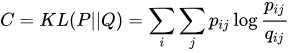

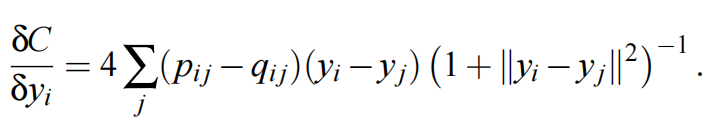

In [10]:
def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=500, max_iter=1000):
  """
    Runs t-SNE on the dataset in the NxD array X to reduce its
    dimensionality to no_dims dimensions. The syntaxis of the function is
    `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    eta - learning rate
  """

  # Check inputs
  if isinstance(no_dims, float):
    print("Error: array X should have type float.")
    return -1
  if round(no_dims) != no_dims:
    print("Error: number of dimensions should be an integer.")
    return -1

  # using PCA to reduce d to init_dims
  X = pca(X, initial_dims).real
  (n, d) = X.shape

  # Compute joint P-values
  P = p_joint(X, perplexity)
  P = P * 4.									# Trick: early exaggeration
  P = np.maximum(P, 1e-12)

  #Initialize randomly for low-dimensional data
  Y = np.random.randn(n, no_dims)

  #hyperparameters of gradient descent with momentum
  initial_momentum = 0.5
  final_momentum = 0.8

  min_gain = 0.01
  dY = np.zeros((n, no_dims)) # gradient
  iY = np.zeros((n, no_dims)) # delta Y
  gains = np.ones((n, no_dims)) # the length of steps

  # early stopping
  tolerance = 1e-4
  patience_counter = 0
  best_error = 99999
  patience_limit = 100

  # Run iterations
  for iter in range(max_iter):

    # Compute pairwise affinities
    Q, num= q_t_distribution(Y)

    # Compute gradient
    PQ = P - Q
    for i in range(n):
      dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

    # Perform the update
    if iter < 20:
      momentum = initial_momentum
    else:
      momentum = final_momentum

    # If dY and iY are in the same direction, gains+=2;
    # otherwise, gains *= 0.8
    # i.e. If the direction of gradient descent remains the same it increases the gains and vice versa.
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
          (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y = Y + iY

    # Ensure that the centre of the distribution remains at the origin in each iteration
    Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    # Compute current value of cost function( KL(P||Q) )
    if (iter + 1) % 100 == 0:
      C = np.sum(P * np.log(P / Q))
      print("Iteration %d: error is %f" % (iter + 1, C))

    # Stop lying about P-values
    if iter == 200:
      P = P / 4.

  # Return solution
  return Y

draw the graph

In [11]:
import matplotlib.pyplot as plt
def draw_pic(X ,labs, name = 't-sne.jpg'):
  plt.cla()
  unque_labs = np.unique(labs)
  colors = [plt.cm.Spectral(each)
    for each in np.linspace(0, 1,len(unque_labs))]
  p=[]
  legends = []
  for i in range(len(unque_labs)):
    index = np.where(labs==unque_labs[i])
    pi = plt.scatter(X[index, 0], X[index, 1], c =[colors[i]] )
    p.append(pi)
    legends.append(unque_labs[i])

  plt.legend(p, legends)
  plt.savefig(name)

# Result

In [12]:
# use 1000 lines for test
np.random.seed(22)

subset = data.sample(1000)
print(subset['label'].value_counts())

8    115
7    114
1    105
5    104
4     98
9     97
0     93
3     92
6     92
2     90
Name: label, dtype: int64


Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.527117
Iteration 100: error is 15.759533
Iteration 200: error is 15.780718
Iteration 300: error is 0.939492
Iteration 400: error is 0.893789
Iteration 500: error is 0.883162
Iteration 600: error is 0.878906
Iteration 700: error is 0.876449
Iteration 800: error is 0.875061
Iteration 900: error is 0.874132
Iteration 1000: error is 0.873456
t-SNE done! Time elapsed: 138.72323417663574 seconds


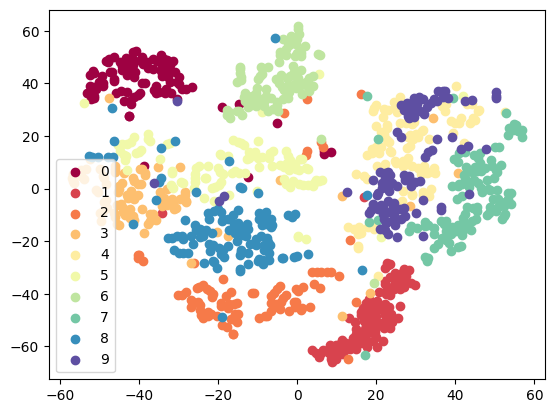

In [13]:
time_start = time.time()

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=600, max_iter=1000) # 1000

draw_pic(Y, labels, name = "final.jpg")
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.646233
Iteration 100: error is 15.549361
Iteration 200: error is 15.549424
Iteration 300: error is 0.912601
Iteration 400: error is 0.872484
Iteration 500: error is 0.864015
Iteration 600: error is 0.858027
Iteration 700: error is 0.856678
Iteration 800: error is 0.855867
Iteration 900: error is 0.855351
Iteration 1000: error is 0.855003
t-SNE done! Time elapsed: 146.26125812530518 seconds


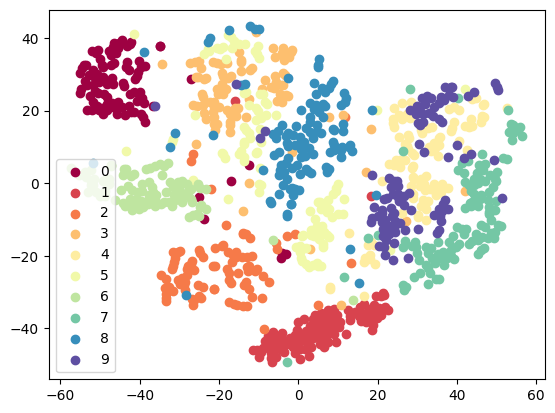

In [ ]:
time_start = time.time()

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne(X, no_dims=2, initial_dims=50, perplexity=40.0, eta=500, max_iter=1000)

draw_pic(Y, labels, name = "final.jpg")
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Mean value of sigma: 2.104070
Iteration 50: error is 17.474752
Iteration 100: error is 17.104185
Iteration 150: error is 1.860589
Iteration 200: error is 1.574273
Iteration 250: error is 1.442264
Iteration 300: error is 1.368554
Iteration 350: error is 1.321939
Iteration 400: error is 1.289742
Iteration 450: error is 1.266464
Iteration 500: error is 1.249030
Iteration 550: error is 1.235546
Iteration 600: error is 1.224906
Iteration 650: error is 1.216301
Iteration 700: error is 1.209230
Iteration 750: error is 1.203434
Iteration 800: error is 1.198554
Iteration 850: error is 1.194404
Iteration 900: error is 1.190831
Iteration 950: error is 1.187763
Iteration 1000: error is 1.185107
t-SNE done! Time elapsed: 979.250629901886 seconds


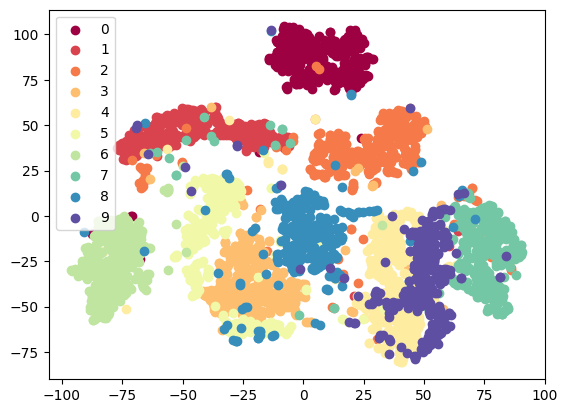

In [ ]:
time_start = time.time()

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne(X, 2, 50, 30.0)

draw_pic(Y, labels, name = "final.jpg")
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Compute joint P for 3500 points
Compute joint P for 4000 points
Compute joint P for 4500 points
Compute joint P for 5000 points
Compute joint P for 5500 points
Compute joint P for 6000 points
Compute joint P for 6500 points
Mean value of sigma: 2.118568
Preprocessing the data using PCA...
Iteration 50: error is 20.045892
Iteration 100: error is 18.785540
Iteration 150: error is 2.430358
Iteration 200: error is 2.112669
Iteration 250: error is 1.941719
Iteration 300: error is 1.832407
Iteration 350: error is 1.755587
Iteration 400: error is 1.699409
Iteration 450: error is 1.656398
Iteration 500: error is 1.622505
Iteration 550: error is 1.595260
Iteration 600: error is 1.572933
Iteration 650: error is 1.554441
Iteration 700: error is 1.538773
Iteration 750: error is 1.5

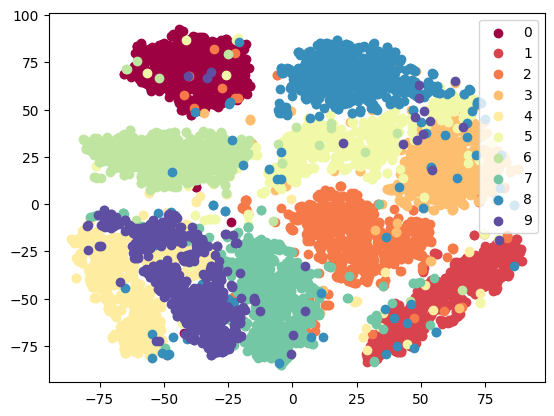

In [ ]:
time_start = time.time()

X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = tsne(X, 2, 50, 30.0)

draw_pic(Y, labels, name = "final.jpg")
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))